# Procesamiento de Imágenes - Trabajo Práctico N°5
## Grupo 3
* Santiago Arribere
* Matías Francois
* Joaquín Gaytan
* Pablo Scheinfeld

# Ejercicio 5 - Regularización y métodos iterativos

## Regularización

Los métodos de restauración por regularización buscan encontrar una solución de compromiso entre la calidad de la restauración y la amplificación del ruido, buscando resolver problemas mal condicionados a partir de otros bien condicionados.

A continuación se utilizará el método de regularización estocástica, el cual permite obtener F (represetación en el dominio de la frecuencia de la imagen restaurada) a partir de:

$$ F(w_x, w_y) = \frac{S_{ff}(w_x, w_y) \cdot H^*(w_x, w_y) \cdot Y(w_x, w_y)}{S_{ff}(w_x, w_y) \cdot |H(w_x, w_y)|^2 +S_{nn}(w_x, w_y) } $$

Donde $S_{ff}(w_x, w_y)$ representa el espectro de potencia de la señal original y $S_{nn}(w_x, w_y)$, el del ruido.


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import sys
# Add the folder path to the sys.path list
sys.path.append('../../src/helpers/')
from mse import mse
from add_noise import add_noise
from blur_img import blur_img

In [23]:
def get_restored_f(img, psf_f, blurred_noisy_f, noise):
  Snn = np.absolute(np.fft.fft2(np.corrcoef(noise)))
  Sff = np.absolute(np.fft.fft2(np.corrcoef(img)))
  
  return np.absolute(np.fft.ifft2((Sff * np.conj(psf_f))* blurred_noisy_f / (Sff * psf_f * np.conj(psf_f) + Snn)))

(512, 512)


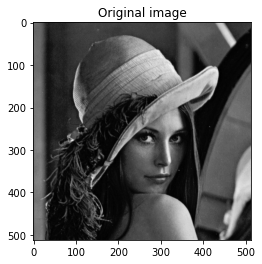

In [24]:
# Open image
img = np.array(Image.open('../../assets/lenagray.tif').convert('L'))

# Plot image
plt.title('Original image')
plt.imshow(img, cmap='gray');
print(img.shape)

### Blur

MSE = 95.11336359863282


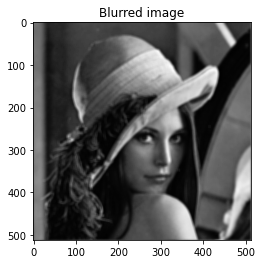

In [25]:

kernel_size = 5
kernel = np.ones((kernel_size, kernel_size)).astype(np.float64)/kernel_size**2
img_h, img_w = img.shape
pad_h = int((img_h - kernel_size) / 2)
pad_w = int((img_w - kernel_size) / 2)

# PSF from kernel
psf = np.pad(kernel, ((pad_h, pad_h), (pad_w, pad_w)), 'constant')
psf_freq = np.fft.fft2(np.fft.ifftshift(psf), s=(512,512))

# Blur image
img_freq = np.fft.fft2(img, s=(512,512))
blurred_img = np.absolute(np.fft.ifft2((psf_freq * img_freq))).astype(np.float64)

# Plot image
plt.title('Blurred image')
plt.imshow(blurred_img, cmap='gray');
print(f'MSE = {mse(img, np.abs(blurred_img))}')

### Noise

noise variance = 539.60


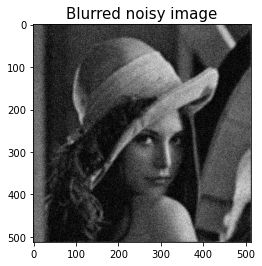

MSE = 573.0612443730191


In [26]:
# Add noise
noisy_blurred_img, noise = add_noise(blurred_img, 65, 'Blurred noisy image')
print(f'MSE = {mse(img, np.abs(noisy_blurred_img))}')

noisy_blurred_img_freq = np.fft.fft2(noisy_blurred_img, s=(512,512))

### Restore

MSE = 155.58041636946177


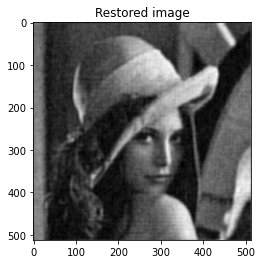

In [27]:
restored = get_restored_f(img, psf_freq, noisy_blurred_img_freq, noise)

# Plot image
plt.title('Restored image')
plt.imshow(restored, cmap='gray');

print(f'MSE = {mse(img, np.abs(restored))}')

Se observa que mediante regularización estocástica fue posible reducir el MSE de la imagen borrosa y con ruido, permitiendo de esta forma corregir en cierta medida dichos efectos.

## Métodos iterativos

Al utilizar métodos iterativos para restaurar las imágenes, no se necesita realizar ninguna inversión. Además, se puede monitorear la restauración entre cada iteración. 


Las principales ventajas de las técnicas iterativas son que no es necesario implementar explícitamente la inversa de un operador y que el proceso puede ser supervisado a medida que avanza. Además, los efectos del ruido pueden controlarse con ciertas restricciones, puede introducirse la adaptabilidad espacial y los parámetros que determinan la solución pueden actualizarse a medida que avanza la iteración. Los algoritmos iterativos son muy adecuados para restaurar imágenes que sufren una variedad de degradaciones, como desenfoques lineales, no lineales, espacialmente variables o espacialmente invariables, y ruido dependiente de la señal, debido al marco flexible que proporciona cada enfoque.

Los métodos iterativos son mucho más flexibles. Pueden ser muy eficientes tanto para desenfoques espacialmente invariantes como para desenfoques espacialmente variantes, pueden incorporar una variedad de técnicas de regularización y condiciones de contorno, y pueden incorporar más fácilmente restricciones adicionales, como la no negatividad.



#### Tikhonov-Miller

Uno de los métodos iterativos más utilizados es el de Tikhonov-Miller, también conocido como regresión de cresta. Este método proporciona una mayor eficiencia en los problemas de estimación de parámetros a cambio de una cantidad tolerable de sesgo. Este tipo de algoritmo depende de un parámetro $\alpha$ que afecta su velocidad de convergencia. El parámetro $\alpha$ a utilizar en el caso de la fotografía antelizada anteriormente se calcula según:

In [28]:
alpha=np.power(noise,2).sum()/np.power(img,2).sum()
print(alpha)

5.30626936603138


A continuación se presenta el flujo a aplicar si se quisieran contrastar los resultados de la restauración realizada mediante un filtro Wiener y mediante el algoritmo iterativo de Tikhonov-Miller.

![](../../assets/ej5/tikhonov.png)

#### Richardson 

Otro algoritmo iterativo es el de Richardson, también conocido como Landweber. Este algoritmo cuenta con la característica de converger muy lentamente. Sin embargo, el método puede acelerarse con una técnica llamada precondicionamiento.


A continuación se muestran los pasos de la iteración de Richardson.


![](../../assets/ej5/richardson.png)